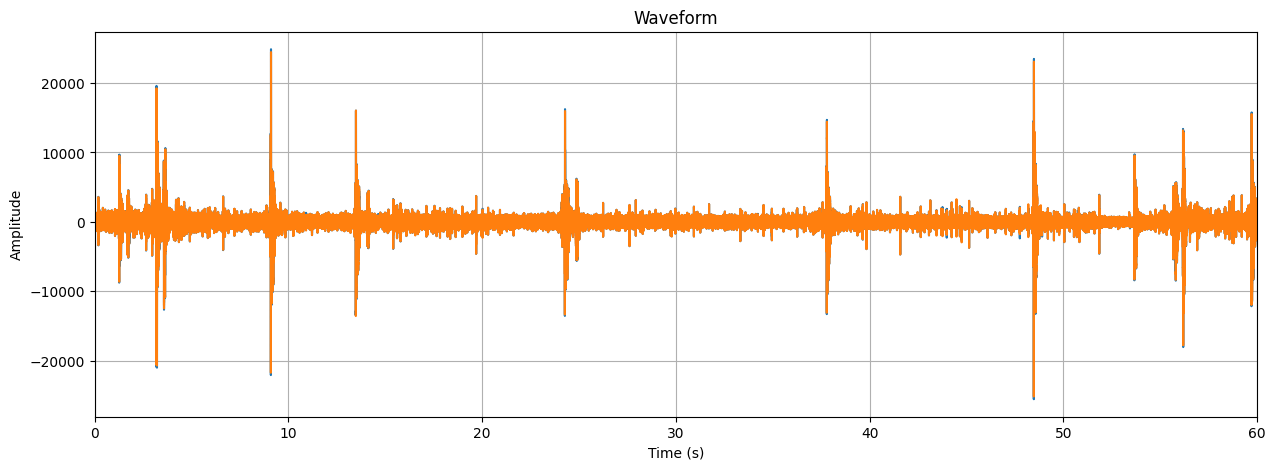

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wavfile

# Load the WAV file
sample_rate, data = wavfile.read('2024-11-09_13.49.00_to_13.49.30.wav')

# Create a time array
times = np.arange(len(data)) / sample_rate

# Plot the waveform
plt.figure(figsize=(15, 5))
plt.plot(times, data)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(times[0], times[-1])
plt.grid()
plt.show()


Sample Rate: 44100 Hz


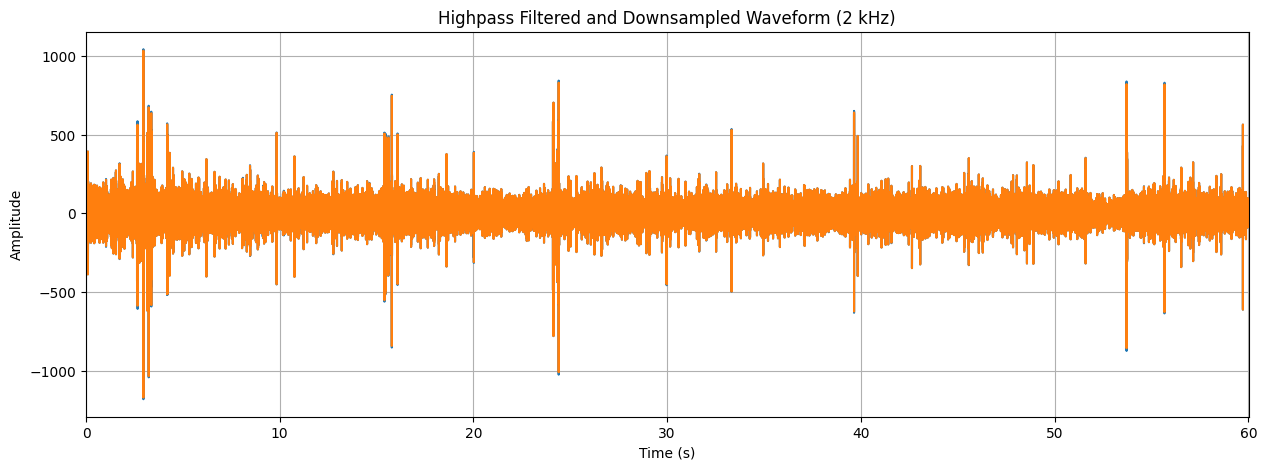

In [30]:
print(f"Sample Rate: {sample_rate} Hz")

# Downsample filtered_data to 2 kHz
from scipy.signal import resample

target_rate = 2000  # Hz
number_of_samples = int(len(filtered_data) * target_rate / sample_rate)

# Resample the data
downsampled_data = resample(filtered_data, number_of_samples)

# Update the times array
downsampled_times = np.linspace(times[0], times[-1], number_of_samples)

# Plot the downsampled waveform
plt.figure(figsize=(15, 5))
plt.plot(downsampled_times, downsampled_data)
plt.title('Highpass Filtered and Downsampled Waveform (2 kHz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(downsampled_times[0], downsampled_times[-1])
plt.grid()
plt.show()

# Update sample_rate for future use
sample_rate = target_rate
times = downsampled_times
data = downsampled_data


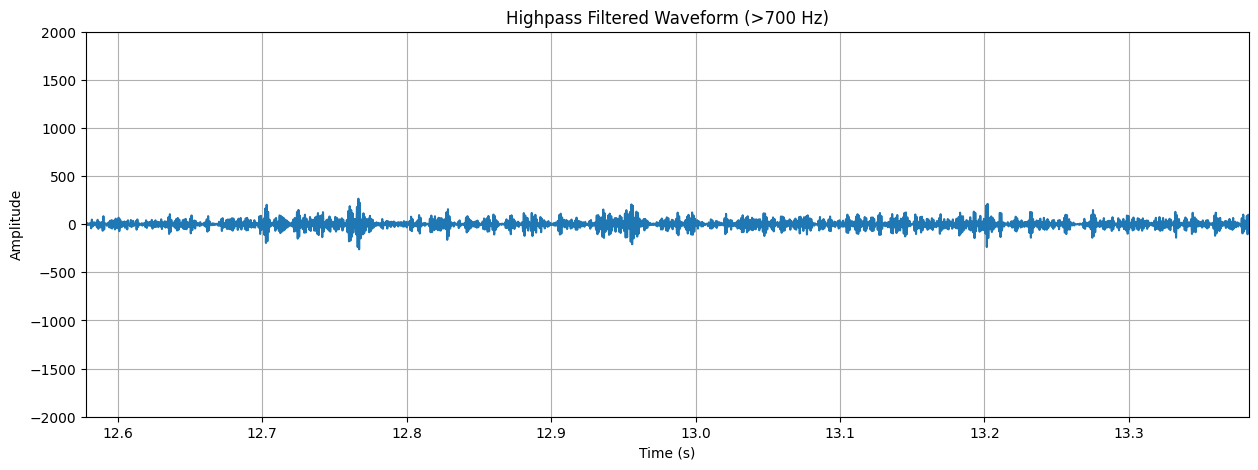

In [31]:
# Apply a high-pass filter above 100 Hz
from scipy.signal import butter, filtfilt

# Design the filter
nyquist = 0.5 * sample_rate
cutoff = 700  # Hz
normal_cutoff = cutoff / nyquist
b, a = butter(N=4, Wn=normal_cutoff, btype='high', analog=False)

# Apply the filter
filtered_data = filtfilt(b, a, data, axis=0)

# Plot the filtered waveform
plt.figure(figsize=(15, 5))
plt.plot(times, downsampled_data[:,0])
plt.title(f'Highpass Filtered Waveform (>{cutoff} Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# plt.xlim(times[0], times[-1])
t0 = 12.5781
t1 = 13.3828
plt.xlim(t0, t1)
plt.ylim([-2000, 2000])
plt.grid()
plt.show()


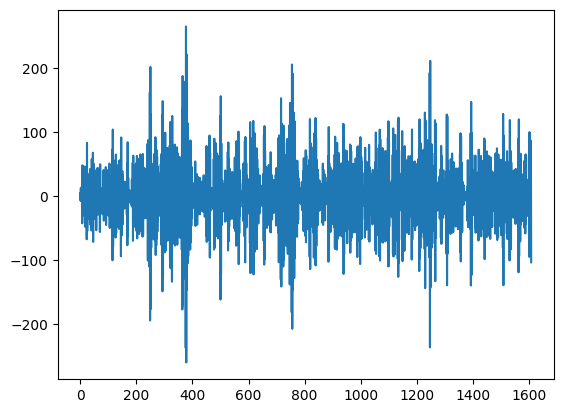

In [32]:
template = downsampled_data[int(t0*sample_rate):int(t1*sample_rate), 0]
plt.plot(template)

In [15]:
import h5py

file = '/1-fnp/petasaur/p-jbod1/das4orcas/incoming/decimator_2024-11-09_21.49.00_UTC_028093.h5'

data = h5py.File(file,'r', locking=False)
attrs=dict(data['Acquisition'].attrs)
das = np.array(data['Acquisition/Raw[0]/RawData'])
time = np.array(data['Acquisition/Raw[0]/RawDataTime'])
data.close()
dt = 1/attrs['MaximumFrequency']/2
dx = attrs['SpatialSamplingInterval']
nt,nx = das.shape

# x = np.linspace(0,nx*dx,nx)
# t = np.linspace(0,nt*dt,nt)

In [16]:
das.shape

(120000, 1567)

In [33]:
from scipy.fft import fft,fft2, ifft2, fftshift

def correlate(s1,s2,mode="same"):

    # throw an error of input sizes are inconsistent
    if s1.shape != s2.shape:
        raise ValueError("s1 and s2 must have the same size!")

    # get fft size
    sz = s1.shape[0]
    n_bits = 1+int(np.log2(2*sz-1))
    fft_sz = 2**n_bits

    # take FFT along time axis for both
    fft_s1 = np.fft.fft(s1, fft_sz, axis=0)
    fft_s2 = np.fft.fft(s2, fft_sz, axis=0)

    # take complex conjugate of second signal
    fft_s2_conj = np.conj(fft_s2)

    # multiply to get correlation function
    corr_fft = fft_s1*fft_s2_conj

    # take inverse fourier transform
    corr = np.fft.ifft(corr_fft, axis=0)

    # normalize using the magnitude of both input data
    norm1 = np.linalg.norm(s1,axis=0)
    norm2 = np.linalg.norm(s2,axis=0)
    norm_factor = norm1*norm2
    corr = np.vstack((corr[-(sz-1) :], corr[:sz]))
    norm_corr = np.real(corr) / norm_factor

    # return desired part of correlation function
    if mode == "full":
        pass
    elif mode == "same":
        norm_corr = norm_corr[int(sz/2):-int(sz/2)+1]
    return norm_corr

def window_and_correlate(template,data):

    # define container
    all_corr = []

    # get some helpful values
    window_length = template.shape[0]
    num_windows = int(data.shape[0]/window_length)
    print(num_windows)

    # iterate through time windows
    for i in range(num_windows):

        # pull out a time window of data
        start_index = i*window_length
        end_index = start_index + window_length
        window = data[start_index:end_index,:]

        # call cross correlation function
        corr = correlate(template,window)

        # save value
        all_corr.append(corr)

    # reshape output
    all_corr = np.stack(all_corr)

    return all_corr

xc = window_and_correlate(template,das)

74


ValueError: s1 and s2 must have the same size!